# 再探torch.nn

pytorch提供了很多设计良好的modules和classed，torch.nn，torch.optim，和Dataset以及Dataloader 来帮助构建和训练神经网络。为了充分利用它们的能力并为自己的问题定制，需要真正地理解它们都在做什么。一个训练神经网络训练识别MNIST数据集的例子。首先只使用最基本的tensor的功能，然后逐步添加torch.nn, torch.optim, Dataset, or DataLoader的特性进去，展示每一块究竟在做什么，以及怎么能让代码更加简洁灵活。

## 数据集设置

MNIST数据集。用pathlib处理路径。使用requests下载数据。

In [6]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

数据集是numpy数组格式，已经用pickle序列化存储。

In [7]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

每个图片都是28×28的，展开为一维784 长度存储的。

In [8]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)
pyplot.show()

(50000, 784)


<Figure size 640x480 with 1 Axes>

PyTorch 使用torch.tensor，而不是numpy数组。所以我们需要转换我们的数据。

In [9]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


## 不使用torch.nn构建神经网络

创建随机tensors，表示权重和偏置，然后告诉这些tensor，它们需要梯度，这就会让PyTorch 记录在tensors上的运算，构建计算图，以使能自动进行反向传播计算。因为初始化这步我们是不想要加入计算图的，所以requires_grad要在初始化之后设置。注意尾部加上_表示变量原地执行该操作。

In [10]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

因为pytorch自动计算梯度的能力，我们可以使用标准的python函数作为model的部分。虽然pytorch准备了很多现成的函数，但到目前为止还是可以轻松地实现自己的版本。pytorch会自动使用GPU加速。

In [11]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

@表示点乘运算，接下来调用函数作用到一个batch的数据上，这称为one forward pass。

In [12]:
bs = 64  # batch size

xb = x_train[0:bs]  # a mini-batch from x
preds = model(xb)  # predictions
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([-2.0446, -1.9517, -2.3846, -2.6700, -1.7815, -2.9094, -2.7893, -2.2573,
        -2.6186, -2.2513], grad_fn=<SelectBackward>) torch.Size([64, 10])


preds张量不仅包含张量值，也有梯度函数，这会被用来做反向传播。接下来还是直接使用python函数做loss计算。

In [13]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

现在看看目前的loss是多少。

In [14]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.2833, grad_fn=<NegBackward>)


现在可以看看模型的精度。

In [15]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()
print(accuracy(preds, yb))

tensor(0.1094)


一次的训练到预测的过程搞定之后，现在可以执行循环，每次迭代的内容是：

- select a mini-batch of data (of size bs)
- use the model to make predictions
- calculate the loss
- loss.backward() updates the gradients of the model, in this case, weights and bias.

在torch.no_grad()环境下执行更新参数的过程。然后在下次loop之前，将梯度设置为0。否则的话梯度会自动累计。

In [16]:
from IPython.core.debugger import set_trace

lr = 0.5  # learning rate
epochs = 2  # how many epochs to train for

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        #         set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

现在我们已经完整地写了一个最小的神经网络了。可以看下现在的结果。

In [17]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0799, grad_fn=<NegBackward>) tensor(1.)


## 使用 torch.nn.functional

现在开始重构代码，使用nn包。每步都使我们的代码更简洁更灵活更易理解。

首先就是用torch.nn.functional代替我们手写的激活函数和损失函数。该module下有很多函数可以使用。

In [19]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

In [20]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0799, grad_fn=<NllLossBackward>) tensor(1.)


## 使用nn.Module

接下来使用 nn.Module and nn.Parameter，继承nn.Module类，获取权重和偏置并做前向计算。nn.Module有很多属性和方法可以使用。

In [21]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias
    
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.2756, grad_fn=<NllLossBackward>)


现在利用model.parameters()和model.zero_grad()，使前面的参数更新过程更加简洁，并且更不容易漏掉某些参数。比如：

```python
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()
```

现在将训练loop放入fit函数，并运行

In [22]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

fit()

看看现在的loss

In [23]:
print(loss_func(model(xb), yb))

tensor(0.0817, grad_fn=<NllLossBackward>)


## 使用nn.Linear

使用nn.Linear定义linear层，替代 xb  @ self.weights + self.bias

In [24]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)
    
model = Mnist_Logistic()
print(loss_func(model(xb), yb))
fit()

print(loss_func(model(xb), yb))

tensor(2.3328, grad_fn=<NllLossBackward>)
tensor(0.0814, grad_fn=<NllLossBackward>)


## 使用optim

torch.optim有很多优化函数。可用它来执行权重更新。

In [25]:
from torch import optim
def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(2.3390, grad_fn=<NllLossBackward>)
tensor(0.0804, grad_fn=<NllLossBackward>)


## 使用Dataset

定义一个子类FacialLandmarkDataset 继承Dataset，重写__len__函数和__getitem__函数。先看看pytorch的TensorDataset，它是一个包含tensors的Dataset。

In [26]:
from torch.utils.data import TensorDataset
train_ds = TensorDataset(x_train, y_train)

可以直接使用对象的索引得到x和y，而不需要再像下面这样分别索引：

```python
xb = x_train[start_i:end_i]
yb = y_train[start_i:end_i]
```

In [27]:
xb,yb = train_ds[i*bs : i*bs+bs]
model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs: i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0827, grad_fn=<NllLossBackward>)


## 使用DataLoader

DataLoader 是用来管理batches的，可以从Dataset创建一个DataLoader，它会使数据batches的循环更容易。DataLoader自动地给出每个minibatch。

In [28]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

之前像这样loop：

```python
for i in range((n-1)//bs + 1):
    xb,yb = train_ds[i*bs : i*bs+bs]
    pred = model(xb)
```

现在可以这样：

In [29]:
model, opt = get_model()

for epoch in range(epochs):
    # 直接取xb, yb
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0825, grad_fn=<NllLossBackward>)


## 添加验证集

为了防止过拟合，验证数据集是必要的。打乱训练数据对防止batches间的相关性和过拟合是很重要的。验证集打不打乱结果是一样的，所以没必要shuffle。

验证集的batchsize设置比训练集大，因为验证集不需要反向传播，因此需要更少的memory。所以这里用两倍的训练集batchsize

In [30]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

现在在每个epoch最后来计算验证集loss

In [31]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

    print(epoch, valid_loss / len(valid_dl))

0 tensor(0.3152)
1 tensor(0.3378)


注意，我们总是在训练之前调用model.train()，这是因为后面会在推断之前调用model.eval()，这时候模型会进入验证模式，所以重新训练之前要先切换回训练模式。它们是用来确保不同的阶段行为是适当的。

## 构建fit() 和 get_data()

专门写一个loss函数计算每个batch的loss，loss_batch。

前向计算的时候需要optimizer，反向的时候是不需要的。

然后构建一个fit函数，还有get_data。这样我们就能非常容易地执行我们的代码了。

In [32]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)
        
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.338123899435997
1 0.30423860963582994


## 转换为CNN

三个卷积层，前面的函数都没有指定模型形式，所以可以直接拿来用以训练 CNN 模型。使用pytorch预定义的Conv2d 类作为卷积层。用三层卷积层定义CNN。每个卷积后是一个ReLU，最后执行一次平均池化，关于CNN的内容可以参考后面 5-cnn-example 文件夹中的文档。

In [33]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

lr = 0.1

view 函数就是 pytorch版本的numpy的reshape函数。Momentum  是随机梯度下降的一种变形，它考虑到以前的更新，通常会使得训练更快。因此使用它：

In [34]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.4330894303798676
1 0.2754692686676979


## nn.Sequential

torch.nn 中还有一个很好用的类，Sequential 。Sequential 对象会以序列的形式运行它之中的每个module。这是一种更简单地编写神经网络的方式。为了利用sequential，对给定的函数，需要继承 nn.Module 定义定制的层。比如：

In [35]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def preprocess(x):
    return x.view(-1, 1, 28, 28)

然后利用该层，就可以构建Sequential

In [36]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3398027998447418
1 0.2788183623671532


## 包装DataLoader

现在CNN已经很简洁了，不过它还只能用到MNIST上，因为：

- 假设了输入是 28\*28 向量
- 假设了最后的CNN grid size是 4\*4 （平均池化 kernel size）

现在如果取消这两个假设，让模型可以应对任意的 2d 单 channel 图片。首先要除掉初始的Lambda层，将数据处理移到一个generator中：

In [38]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

可以使用 nn.AdaptiveAvgPool2d  替换 nn.AvgPool2d ， 这允许我们定义输出tensor的大小为我们想要的而不是我们现在有的。现在就可以这样了：

In [39]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3950530921459198
1 0.24604604278206826


## 使用GPU

首先检查自己的GPU是否可用：

In [40]:
print(torch.cuda.is_available())

False


然后可以创建一个设备对象：

In [ ]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

将数据放入设备对象中：

In [ ]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)


train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

模型也放入设备中，就可以快速计算了。

In [ ]:
model.to(dev)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

## Dropout

在模型训练中，dropout是个比较重要的环节，以下给出一个示例。

参考：[Dropout在RNN中的应用综述](https://lonepatient.top/2018/09/24/a-review-of-dropout-as-applied-to-rnns.html)

受性别在进化中的作用的启发，Hinton等人最先提出Dropout，即暂时从网络中**移除神经网络中的单元**。 Srivastava等人将Dropout应用于前馈神经网络和受限玻尔兹曼机，其工作的核心概念是“在加入了dropout的神经网络在训练时，每个隐藏单元必须学会随机选择其他单元样本。这理应使每个隐藏的单元更加健壮，并驱使它**自己学到有用的特征，而不依赖于其他隐藏的单元**来纠正它的错误“。

在标准神经网络中，每个参数通过梯度下降逐渐优化达到全局最小值。因此，**隐藏单元可能会为了修正其他单元的错误而更新参数**。这可能导致“共适应”，反过来会导致过拟合。而假设通过使其他隐藏单元的存在不可靠，dropout阻止了每个隐藏单元的共适应。

随着**数据集变大，dropout的增益增加到一个点然后下降**。 这表明，对于任何给定的网络结构和dropout率，存在一个“最佳点”。

用伯努利分别来表示隐藏单元被激活的概率，其中值1为概率p，否则为0。
$$P(n)=
\left\{\begin{matrix}
 1-p  \ \ \  for \ n=0 \\ 
 p    \ \ \ \ \ \ \ \  for \ n=1
\end{matrix}\right.$$

代码如下所示

In [ ]:
class Dropout():
    def __init__(self, prob=0.5):
        self.prob = prob
        self.params = []
    def forward(self,X):
        self.mask = np.random.binomial(1,self.prob,size=X.shape) / self.prob
        out = X * self.mask
    return out.reshape(X.shape)
    def backward(self,dout):
        dX = dout * self.mask
        return dX,[]

在Dropout之后，Wan等人的进一步提出了DropConnect，它“通过**随机丢弃权重而不是激活来扩展Dropout**”。 “使用Drop Connect, drop的是每个连接，而不是每个输出单元。”与Dropout一样，该技术仅适用于全连接层。

通过将dropout应用于输入权重而不是激活，DropConnect可以推广到全连接网络层的整个连接结构。

有dropout的神经网络和没有的区别：

一个是在神经网络结构中增加dropout层；另一个，注意dropout有两个mode，一是对train data的，一个是对test data的。在train data中进行dropout，但是在test data中是不用的"""

In [ ]:
# https://deeplearningcourses.com/c/data-science-deep-learning-in-theano-tensorflow
# https://www.udemy.com/data-science-deep-learning-in-theano-tensorflow
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future

# Note: is helpful to look at keras_example.py first


import numpy as np
import matplotlib.pyplot as plt
from util import get_normalized_data

import torch
from torch.autograd import Variable
from torch import optim

# get the data, same as Theano + Tensorflow examples
# no need to split now, the fit() function will do it
Xtrain, Xtest, Ytrain, Ytest = get_normalized_data()

# get shapes
_, D = Xtrain.shape
K = len(set(Ytrain))

# Note: no need to convert Y to indicator matrix


# the model will be a sequence of layers
model = torch.nn.Sequential()

# ANN with layers [784] -> [500] -> [300] -> [10]
# NOTE: the "p" is p_drop, not p_keep
model.add_module("dropout1", torch.nn.Dropout(p=0.2))
model.add_module("dense1", torch.nn.Linear(D, 500))
model.add_module("relu1", torch.nn.ReLU())
model.add_module("dropout2", torch.nn.Dropout(p=0.5))
model.add_module("dense2", torch.nn.Linear(500, 300))
model.add_module("relu2", torch.nn.ReLU())
model.add_module("dropout3", torch.nn.Dropout(p=0.5))
model.add_module("dense3", torch.nn.Linear(300, K))
# Note: no final softmax!
# just like Tensorflow, it's included in cross-entropy function


# define a loss function
# other loss functions can be found here:
# http://pytorch.org/docs/master/nn.html#loss-functions
loss = torch.nn.CrossEntropyLoss(size_average=True)
# Note: this returns a function!
# e.g. use it like: loss(logits, labels)


# define an optimizer
# other optimizers can be found here:
# http://pytorch.org/docs/master/optim.html
optimizer = optim.Adam(model.parameters(), lr=1e-4)


# define the training procedure
# i.e. one step of gradient descent
# there are lots of steps
# so we encapsulate it in a function
# Note: inputs and labels are torch tensors
def train(model, loss, optimizer, inputs, labels):
    # set the model to training mode
    # because dropout has 2 different modes!
    model.train()

    inputs = Variable(inputs, requires_grad=False)
    labels = Variable(labels, requires_grad=False)

    # Reset gradient
    optimizer.zero_grad()

    # Forward
    logits = model.forward(inputs)
    output = loss.forward(logits, labels)

    # Backward
    output.backward()

    # Update parameters
    optimizer.step()

    # what's the difference between backward() and step()?

    return output.item()


# similar to train() but not doing the backprop step
def get_cost(model, loss, inputs, labels):
    # set the model to testing mode
    # because dropout has 2 different modes!
    model.eval()

    inputs = Variable(inputs, requires_grad=False)
    labels = Variable(labels, requires_grad=False)

    # Forward
    logits = model.forward(inputs)
    output = loss.forward(logits, labels)

    return output.item()


# define the prediction procedure
# also encapsulate these steps
# Note: inputs is a torch tensor
def predict(model, inputs):
    # set the model to testing mode
    # because dropout has 2 different modes!
    model.eval()

    inputs = Variable(inputs, requires_grad=False)
    logits = model.forward(inputs)
    return logits.data.numpy().argmax(axis=1)


# return the accuracy
# labels is a torch tensor
# to get back the internal numpy data
# use the instance method .numpy()
def score(model, inputs, labels):
    predictions = predict(model, inputs)
    return np.mean(labels.numpy() == predictions)


### prepare for training loop ###

# convert the data arrays into torch tensors
Xtrain = torch.from_numpy(Xtrain).float()
Ytrain = torch.from_numpy(Ytrain).long()
Xtest = torch.from_numpy(Xtest).float()
Ytest = torch.from_numpy(Ytest).long()

# training parameters
epochs = 15
batch_size = 32
n_batches = Xtrain.size()[0] // batch_size

# things to keep track of
train_costs = []
test_costs = []
train_accuracies = []
test_accuracies = []

# main training loop
for i in range(epochs):
    cost = 0
    test_cost = 0
    for j in range(n_batches):
        Xbatch = Xtrain[j * batch_size:(j + 1) * batch_size]
        Ybatch = Ytrain[j * batch_size:(j + 1) * batch_size]
        cost += train(model, loss, optimizer, Xbatch, Ybatch)

    # we could have also calculated the train cost here
    # but I wanted to show you that we could also return it
    # from the train function itself
    train_acc = score(model, Xtrain, Ytrain)
    test_acc = score(model, Xtest, Ytest)
    test_cost = get_cost(model, loss, Xtest, Ytest)

    print("Epoch: %d, cost: %f, acc: %.2f" % (i, test_cost, test_acc))

    # for plotting
    train_costs.append(cost / n_batches)
    train_accuracies.append(train_acc)
    test_costs.append(test_cost)
    test_accuracies.append(test_acc)

# plot the results
plt.plot(train_costs, label='Train cost')
plt.plot(test_costs, label='Test cost')
plt.title('Cost')
plt.legend()
plt.show()

plt.plot(train_accuracies, label='Train accuracy')
plt.plot(test_accuracies, label='Test accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

## 小结

简单复习下步骤：

获取数据，包括归一化处理—>构建神经网络结果，主要是定义layer，完成参数初始化—>定义forward函数，主要是每层计算输出，包括定义激活函数—>定义损失函数、优化算法—>注意要先将数据定义到张量中，然后调用函数式地调用神经网络对象以调用forward计算—>计算loss并由loss张量完成自动梯度计算反向传播—>调用优化算法的step完成参数更新—>梯度归零（也可以放在loss反向传播之前），开始新一轮循环参数更新。

上述步骤中，除了重写Module之外，直接利用Sequential构建神经网络结构也是一种常见做法。

接下来利用pytorch写一个神经网络的示例来自课程《Mordern deep learning in Python》。

Reading in and transforming data...


C:\Users\hust2\Anaconda3\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch: 0, cost: 0.251691, acc: 0.96
Epoch: 1, cost: 0.117666, acc: 0.97
Epoch: 2, cost: 0.082470, acc: 0.97
Epoch: 3, cost: 0.054635, acc: 0.97
Epoch: 4, cost: 0.060924, acc: 0.97
Epoch: 5, cost: 0.052717, acc: 0.97
Epoch: 6, cost: 0.039973, acc: 0.98
Epoch: 7, cost: 0.034754, acc: 0.97
Epoch: 8, cost: 0.044111, acc: 0.98
Epoch: 9, cost: 0.050160, acc: 0.98
Epoch: 10, cost: 0.031708, acc: 0.98
Epoch: 11, cost: 0.042624, acc: 0.98
Epoch: 12, cost: 0.030264, acc: 0.98
Epoch: 13, cost: 0.032563, acc: 0.98
Epoch: 14, cost: 0.027656, acc: 0.98


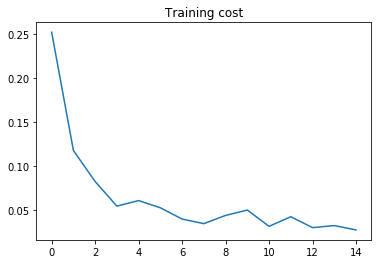

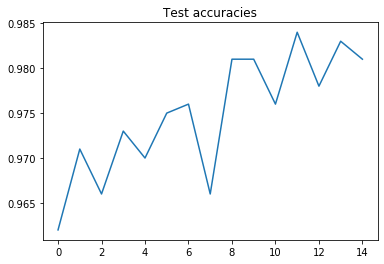

In [3]:
import os
import pandas as pd
import numpy as np


def get_normalized_data():
    """获取数据"""
    print("Reading in and transforming data...")

    if not os.path.exists('data/mnist/train.csv'):
        print('Looking for data/mnist/train.csv')
        print('You have not downloaded the data and/or not placed the files in the correct location.')
        print('Please get the data from: https://www.kaggle.com/c/digit-recognizer')
        print('Place train.csv in the folder data adjacent to the class folder')
        exit()

    df = pd.read_csv('data/mnist/train.csv')
    data = df.values.astype(np.float32)
    np.random.shuffle(data)
    X = data[:, 1:]
    Y = data[:, 0]

    Xtrain = X[:-1000]
    Ytrain = Y[:-1000]
    Xtest = X[-1000:]
    Ytest = Y[-1000:]

    # normalize the data
    mu = Xtrain.mean(axis=0)
    std = Xtrain.std(axis=0)
    np.place(std, std == 0, 1)
    Xtrain = (Xtrain - mu) / std
    Xtest = (Xtest - mu) / std

    return Xtrain, Xtest, Ytrain, Ytest

import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch import optim
import torch

# 第一步是load data，这里采用的是deep learning里的hello world，即识别手写数字的数据集，来自kaggle。
# get the data,
# no need to split now, the fit() function will do it
Xtrain, Xtest, Ytrain, Ytest = get_normalized_data()

# get shapes
_, D = Xtrain.shape
K = len(set(Ytrain))

# 第二步是构建网络结构，使用pytorch构建神经网络要比直接通过numpy手写简单很多，这里先构建一个sequential（和Keras类似），然后逐层添加网络结构即可。
model = torch.nn.Sequential()
# 逐层添加网络即可，在pytorch中是采用add_module()函数。第一个参数是当前层的命名，可以取任何想要的名称。第二个参数就是该层。层要么是linear transformation，要么是activation
# 比如第一层，Linear,参数D是输入的神经元个数，第二个参数500是输出的神经元个数
model.add_module("dense1", torch.nn.Linear(D, 500))
model.add_module("relu1", torch.nn.ReLU())
model.add_module("dense2", torch.nn.Linear(500, 300))
model.add_module("relu2", torch.nn.ReLU())
model.add_module("dense3", torch.nn.Linear(300, K))
# 第三步是构建loss函数，loss函数详情可参考http://pytorch.org/docs/master/nn.html#loss-functions
loss = torch.nn.CrossEntropyLoss(size_average=True)
# 第四步是设置优化函数，Adam是一种常用的优化算法，是一种改良的GD算法。算法需要神经网络的parameters作为参数。
optimizer = optim.Adam(model.parameters())


# 第五步是定义训练过程和预测过程，这部分也是相对最难掌握的一部分。这部分相对TensorFlow和Theano都会麻烦一些。


def train(model, loss, optimizer, inputs, labels):
    """训练过程主要包括：包装输入输出到Variable变量，初始化优化函数，前向传播，反向传播，以及参数更新，详情见每步解释"""
    # 为什么要包装变量到Variable：把Tensor包装到Variable中，它就会开始保存所有计算历史。因此每次运算都会稍微多一些cost；另一方面，在训练循环外部对Variable进行计算操作相对容易。不包装也是可以计算的，并且后面的pytorch版本有柯南高就不需要Variable的这一步了
    inputs = Variable(inputs, requires_grad=False)
    labels = Variable(labels, requires_grad=False)

    # pytorch的梯度计算是累计的，这对有些神经网络是比较好的，因此这里初始化为0
    optimizer.zero_grad()

    # 直接调用model的前向函数即可得到输出
    logits = model.forward(inputs)

    # 然后计算loss
    output = loss.forward(logits, labels)

    # 接着就是进行反向传播计算
    output.backward()

    # 最后是更新参数
    optimizer.step()

    return output.item()


def predict(model, inputs):
    inputs = Variable(inputs, requires_grad=False)
    logits = model.forward(inputs)
    # argmax函数是给出axis维上数组中最大数的索引
    return logits.data.numpy().argmax(axis=1)


# 第六步定义各类超参数并开始训练过程
# 首先是将numpy变量都设置为torch中的张量，注意要指定数据类型
Xtrain = torch.from_numpy(Xtrain).float()
Ytrain = torch.from_numpy(Ytrain).long()
Xtest = torch.from_numpy(Xtest).float()

epochs = 15
batch_size = 32  # 每个batch的大小
n_batches = Xtrain.size()[0] // batch_size  # batch的个数

costs = []
test_accuracies = []
for i in range(epochs):
    cost = 0.
    for j in range(n_batches):
        Xbatch = Xtrain[j * batch_size:(j + 1) * batch_size]
        Ybatch = Ytrain[j * batch_size:(j + 1) * batch_size]
        cost += train(model, loss, optimizer, Xbatch, Ybatch)

    Ypred = predict(model, Xtest)
    acc = np.mean(Ytest == Ypred)
    print("Epoch: %d, cost: %f, acc: %.2f" % (i, cost / n_batches, acc))

    costs.append(cost / n_batches)
    test_accuracies.append(acc)

# 第七步是将训练过程可视化,# EXERCISE: plot test cost + training accuracy too。一般都是把cost和accuracy都可视化出来
# plot the results
plt.plot(costs)
plt.title('Training cost')
plt.show()

plt.plot(test_accuracies)
plt.title('Test accuracies')
plt.show()